In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/')

! pip install --upgrade albumentations
import albumentations as A

from copy import copy

import numpy as np
import matplotlib.pyplot as plt
import gc
import tqdm
from sklearn.model_selection import StratifiedKFold
import cv2

import torch
torch.backends.cudnn.benchmark = True
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, Subset

!pip install catalyst
from catalyst import utils, dl, callbacks
SEED = 42
utils.set_global_seed(SEED)
utils.prepare_cudnn(deterministic=True)

!pip install segmentation_models_pytorch
import segmentation_models_pytorch as smp

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).
Requirement already up-to-date: albumentations in /usr/local/lib/python3.6/dist-packages (0.5.2)


In [ ]:
competition_path = "/content/gdrive/My Drive/Seismic Facies Identification/"
data_path = competition_path + "data/"
train_img = np.load(data_path+'data_train.npz', allow_pickle=True, mmap_mode='r')['data']
train_labels = np.load(data_path+'labels_train.npz', allow_pickle=True, mmap_mode='r')['labels']
test1_img = np.load(data_path+'data_test_1.npz', allow_pickle=True, mmap_mode='r')['data']
test2_img = np.load(data_path+'data_test_2.npz', allow_pickle=True, mmap_mode='r')['data']
train_labels -= 1
train_labels[:,0,:] = train_labels[:,1,:]

pseudo_label = False
# add pseudo-label images
if pseudo_label:
  pseudo_pct = 0.5
  submission_file_test1 = competition_path + "round 1 submissions/prediction20_DLV3Plus_resnext50_32x4d.npz"
  #submission_file_test1 = competition_path + "submissions/prediction_test1_h.npz"
  submission_file_test2 = competition_path + "submissions/prediction34_class5_CE_1_5.npz"
  # add images from test1
  pred = np.load(submission_file_test1, mmap_mode='r')['prediction']
  pred -= 1
  pseudo_image_nb_h = int(test1_img.shape[2] * pseudo_pct)
  train_img = np.concatenate((train_img, test1_img[:,:,:pseudo_image_nb_h]), axis=2)
  train_labels = np.concatenate((train_labels, pred[:,:,:pseudo_image_nb_h]), axis=2)
  # add images from test2
  pred = np.load(submission_file_test2, mmap_mode='r')['prediction']
  pred -= 1
  pseudo_image_nb_h = train_img.shape[2]
  pseudo_image_nb_v = int(test2_img.shape[1] * pseudo_pct)
  train_img = np.concatenate((train_img, test2_img[:,:pseudo_image_nb_v,:pseudo_image_nb_h]), axis=1)
  train_labels = np.concatenate((train_labels, pred[:,:pseudo_image_nb_v,:pseudo_image_nb_h]), axis=1)
  print(train_img.shape)

# merge labels for binary classification
binary_class = "class_0123" # "class_4", "class_5", "class_0123" or "class_012345"
if binary_class == "class_012345":
  classes = 6
  weights = [1, 1, 1, 1, 10, 1]
elif binary_class == "class_0123":
  classes = 4
  weights = [1, 5, 1, 10]
  train_labels[train_labels==4] = 1
  train_labels[train_labels==5] = 1
elif binary_class == "class_4":
  train_img = train_img[170:618, :, :448] # crop images
  train_labels = train_labels[170:618, :, :448] # crop images
  classes = 2
  train_labels[train_labels==1] = 0
  train_labels[train_labels==2] = 0
  train_labels[train_labels==3] = 0
  train_labels[train_labels==4] = 1
  train_labels[train_labels==5] = 0
elif binary_class == "class_5":
  train_img = train_img[92:636, :, :] # crop images
  train_labels = train_labels[92:636, :, :] # crop images
  classes = 2
  weights = [1, 5]
  train_labels[train_labels==1] = 0
  train_labels[train_labels==2] = 0
  train_labels[train_labels==3] = 0
  train_labels[train_labels==4] = 0
  train_labels[train_labels==5] = 1

print(f"train_img {train_img.shape} train_lables {train_labels.shape} test1_img {test1_img.shape} test2_img {test2_img.shape}")

"""
# normalize values to [0, 1]
_min = min(train_img.min(), test1_img.min(), test2_img.min())
_max = max(train_img.max(), test1_img.max(), test2_img.max())
train_img = (train_img - _min) / (_max - _min)
test1_img = (test1_img - _min) / (_max - _min)
test2_img = (test2_img - _min) / (_max - _min)
"""
# normalize values to max(abs())==1
_min = min(train_img.min(), test1_img.min(), test2_img.min())
_max = max(train_img.max(), test1_img.max(), test2_img.max())
divide = max(-_min, _max)
train_img = train_img / divide
test1_img = test1_img / divide
test2_img = test2_img / divide

def calculate_weights(train_labels):
  labels = [0, 1, 2, 3, 4, 5]
  weights = []
  for label in labels:
    weights.append(train_labels.size / np.sum(train_labels==label) / len(labels))
  return weights

#weights = calculate_weights(train_labels)
#print(weights)

train_img (1006, 782, 590) train_lables (1006, 782, 590) test1_img (1006, 782, 251) test2_img (1006, 334, 841)


In [ ]:
def train_transform(image, mask):
  if binary_class == "class_012345" or binary_class == "class_0123":
    height = 896
    width = 256
  elif binary_class == "class_4":
    height = 448
    width = 448
  elif binary_class == "class_5":
    height = 544
    width = 256
  return A.Compose([   
    A.ShiftScaleRotate(p=0.7, shift_limit=0, scale_limit=0.15, rotate_limit=25),
    #A.Rotate(p=0.8, limit=25, interpolation=cv2.INTER_LINEAR), # cv2.INTER_LINEAR or cv2.INTER_NEAREST
    #A.OneOf([
    #     A.ShiftScaleRotate(p=0.8, shift_limit=0, scale_limit=0.15, rotate_limit=25),
    #     A.IAAPiecewiseAffine(p=0.8, scale=(0.03, 0.12), nb_rows=4, nb_cols=4),
    #], p=1),
    A.RandomCrop(p=1, height=height, width=width),
    A.MultiplicativeNoise(p=0.7, multiplier=(0.8, 1.2), per_channel=False, elementwise=False),
    #A.GaussNoise(p=0.8, var_limit=(10.0, 50.0)), # var_limit to be optimized
    A.HorizontalFlip(p=0.5),
  ])(image=image, mask=mask)

def valid_transform(image, mask):
  if binary_class == "class_012345" or binary_class == "class_0123":
    height = 1024
    width = 800
  elif binary_class == "class_4":
    height = 448
    width = 448
  elif binary_class == "class_5":
    height = 544
    width = 800
  return A.Compose([
    A.PadIfNeeded(p=1, min_height=height, min_width=width), # border_mode=4 reflect_101 
  ])(image=image, mask=mask)

In [ ]:
class SeismicFaciesDataset(Dataset):
  def __init__(self, img, labels, train=True, both_axis=True, channels=3):
    self.img = img
    self.labels = labels
    self.train = train
    self.both_axis = both_axis
    self.channels = channels
    self.side_channels = int((channels - 1) / 2)
    self.xaxis = self.img.shape[1]
    self.yaxis = self.img.shape[2]
    self.ximages = self.xaxis - self.side_channels * 2
    self.yimages = self.yaxis - self.side_channels * 2

  def __len__(self):
    if self.both_axis:
      return self.ximages + self.yimages
    else:
      return self.yimages

  def __getitem__(self, idx):
    if idx < self.yimages:
      image, mask = self.img[:, :, idx:idx+self.channels], self.labels[:, :, idx+self.side_channels]
    else:
      idx = idx - self.yimages
      image, mask = self.img[:, idx:idx+self.channels], self.labels[:, idx+self.side_channels]
      image = np.moveaxis(image, 1, 2)

    if self.train:
      augmented = train_transform(image, mask)
    else:
      augmented = valid_transform(image, mask)
    image, mask = augmented['image'], augmented['mask']
        
    return [np.moveaxis(image, 2, 0), np.expand_dims(mask, 0)]


class SeismicFaciesTestset(Dataset):
  def __init__(self, img, batch_axis=2, channels=3): # batch_axis = 1 (x_axis) or 2 (y_axis)
    self.img = img
    self.batch_axis = batch_axis
    self.channels = channels
    self.side_channels = int((channels - 1) / 2)
    self.image_nb = self.img.shape[self.batch_axis]

  def __len__(self):
    return self.image_nb

  def __getitem__(self, idx):
    if idx < self.side_channels:
      idx = self.side_channels
    
    if idx > self.image_nb-self.side_channels-1:
      idx = self.image_nb-self.side_channels-1
    if self.batch_axis == 2:
      image = self.img[:, :, idx-self.side_channels:idx+self.side_channels+1]
    else:
      image = self.img[:, idx-self.side_channels:idx+self.side_channels+1, :]
      image = np.moveaxis(image, 1, 2)

    #image = A.PadIfNeeded(p=1, min_height=1024, min_width=800)(image=image)["image"]
    bboxes = [[0, 0, image.shape[1], image.shape[0], "original_image"]] # width and then height
    augmented = A.Compose([
          A.PadIfNeeded(p=1, min_height=1024, min_width=1024),
          ], bbox_params=A.BboxParams(format='coco'))(image=image, bboxes=bboxes)
    image, self.bboxes = augmented["image"], augmented["bboxes"]
    return [np.moveaxis(image, 2, 0)]

In [ ]:
class GDiceLoss(torch.nn.Module):
    def __init__(self, apply_nonlin=None, smooth=1e-5):
        """
        Generalized Dice;
        Copy from: https://github.com/LIVIAETS/surface-loss/blob/108bd9892adca476e6cdf424124bc6268707498e/losses.py#L29
        paper: https://arxiv.org/pdf/1707.03237.pdf
        tf code: https://github.com/NifTK/NiftyNet/blob/dev/niftynet/layer/loss_segmentation.py#L279
        """
        super(GDiceLoss, self).__init__()

        self.apply_nonlin = apply_nonlin
        self.smooth = smooth

    def forward(self, net_output, gt):
        shp_x = net_output.shape # (batch size,class_num,x,y,z)
        shp_y = gt.shape # (batch size,1,x,y,z)
        # one hot code for gt
        with torch.no_grad():
            if len(shp_x) != len(shp_y):
                gt = gt.view((shp_y[0], 1, *shp_y[1:]))

            if all([i == j for i, j in zip(net_output.shape, gt.shape)]):
                # if this is the case then gt is probably already a one hot encoding
                y_onehot = gt
            else:
                gt = gt.long()
                y_onehot = torch.zeros(shp_x)
                if net_output.device.type == "cuda":
                    y_onehot = y_onehot.cuda(net_output.device.index)
                y_onehot.scatter_(1, gt, 1)


        if self.apply_nonlin is not None:
            net_output = self.apply_nonlin(net_output)
    
        # copy from https://github.com/LIVIAETS/surface-loss/blob/108bd9892adca476e6cdf424124bc6268707498e/losses.py#L29
        w: torch.Tensor = 1 / (torch.einsum("bcxy->bc", y_onehot).type(torch.float32) + 1e-10)**2
        intersection: torch.Tensor = w * torch.einsum("bcxy, bcxy->bc", net_output, y_onehot)
        union: torch.Tensor = w * (torch.einsum("bcxy->bc", net_output) + torch.einsum("bcxy->bc", y_onehot))
        divided: torch.Tensor =  - 2 * (torch.einsum("bc->b", intersection) + self.smooth) / (torch.einsum("bc->b", union) + self.smooth)
        gdc = divided.mean()

        return gdc


def flatten(tensor):
    """Flattens a given tensor such that the channel axis is first.
    The shapes are transformed as follows:
       (N, C, D, H, W) -> (C, N * D * H * W)
    """
    C = tensor.size(1)
    # new axis order
    axis_order = (1, 0) + tuple(range(2, tensor.dim()))
    # Transpose: (N, C, D, H, W) -> (C, N, D, H, W)
    transposed = tensor.permute(axis_order).contiguous()
    # Flatten: (C, N, D, H, W) -> (C, N * D * H * W)
    return transposed.view(C, -1)

class GDiceLossV2(torch.nn.Module):
    def __init__(self, apply_nonlin=None, smooth=1e-5):
        """
        Generalized Dice;
        Copy from: https://github.com/wolny/pytorch-3dunet/blob/6e5a24b6438f8c631289c10638a17dea14d42051/unet3d/losses.py#L75
        paper: https://arxiv.org/pdf/1707.03237.pdf
        tf code: https://github.com/NifTK/NiftyNet/blob/dev/niftynet/layer/loss_segmentation.py#L279
        """
        super(GDiceLossV2, self).__init__()

        self.apply_nonlin = apply_nonlin
        self.smooth = smooth

    def forward(self, net_output, gt):
        shp_x = net_output.shape # (batch size,class_num,x,y,z)
        shp_y = gt.shape # (batch size,1,x,y,z)
        # one hot code for gt
        with torch.no_grad():
            if len(shp_x) != len(shp_y):
                gt = gt.view((shp_y[0], 1, *shp_y[1:]))

            if all([i == j for i, j in zip(net_output.shape, gt.shape)]):
                # if this is the case then gt is probably already a one hot encoding
                y_onehot = gt
            else:
                gt = gt.long()
                y_onehot = torch.zeros(shp_x)
                if net_output.device.type == "cuda":
                    y_onehot = y_onehot.cuda(net_output.device.index)
                y_onehot.scatter_(1, gt, 1)


        if self.apply_nonlin is not None:
            net_output = self.apply_nonlin(net_output)

        input = flatten(net_output)
        target = flatten(y_onehot)
        target = target.float()
        target_sum = target.sum(-1)
        #weights_base = [1.539948, 0.4490113, 6.48968674, 0.50709277, 11.38007304, 1.09947775]
          # weights_base is calculated by : np.array(calculate_weights(train_labels[:,-50:,:]))
        weights = [1.539948, 0.4490113, 6.48968674, 0.50709277] # (for class0123)
        #weights = [1.539948, 0.4490113, 6.48968674, 0.50709277, 113.8007304, 1.09947775] # weights_base*[1,1,1,1,10,1] (for class4)
        #weights = [1.539948, 0.4490113, 6.48968674, 0.50709277, 11.38007304, 5.49738875] # weights_base**[1,1,1,1,1,5] (for class5)
        class_weights = torch.tensor(weights).cuda(net_output.device.index)

        intersect = (input * target).sum(-1) * class_weights
        intersect = intersect.sum()

        denominator = ((input + target).sum(-1) * class_weights).sum()

        return  - 2. * intersect / denominator.clamp(min=self.smooth)


In [ ]:
import catalyst
import sklearn

# catalyst pipeline
channels = 1
batch_size = 8
valid_batch_size = 4

class CustomRunner(dl.Runner):

  def predict_batch(self, batch):
      # model inference step
      return self.model(batch[0].to(self.device))

  def _handle_batch(self, batch):
      # model train/valid step
      x, y = batch
      y_hat = self.model(x)
      
      loss = self.criterion["CE"](y_hat, torch.squeeze(y.long()))*0.3 + self.criterion["GDice"](y_hat, torch.squeeze(y.long()))*0.7
      y_hat_reshaped = y_hat.permute(0, 2, 3, 1).reshape(-1, classes)
      y_reshaped = y.permute(0, 2, 3, 1).reshape(-1, 1)
      #f1_score = sklearn.metrics.f1_score(y_reshaped.cpu().detach().numpy(), y_hat_reshaped.cpu().detach().numpy().argmax(axis=1), average='macro')
      #accuracy01, accuracy02 = catalyst.metrics.accuracy(y_hat_reshaped, y_reshaped, topk=(1, 2))
      [accuracy01] = catalyst.metrics.accuracy(y_hat_reshaped, y_reshaped)
      f1_score = catalyst.metrics.f1_score(torch.argmax(y_hat_reshaped, dim=1, keepdims=True), y_reshaped, num_classes=classes)

      self.batch_metrics.update(
          {"loss": loss, "accuracy_01": accuracy01, "f1_score": torch.mean(f1_score)} # "accuracy_2": accuracy02, "f1_score": f1_score
      )

      if self.is_train_loader:
          loss.backward()
          self.optimizer.step()
          self.optimizer.zero_grad()

#model = smp.Unet(encoder_name="efficientnet-b3", in_channels=channels, classes=classes, activation="softmax", decoder_attention_type="scse", encoder_weights='imagenet')
model = smp.DeepLabV3Plus(encoder_name="efficientnet-b3", in_channels=channels, classes=classes, activation="softmax", encoder_weights='imagenet')
#model = smp.DeepLabV3Plus(encoder_name="resnext50_32x4d", in_channels=channels, classes=classes, activation="softmax", encoder_weights='imagenet')
#model = smp.DeepLabV3Plus(encoder_name="se_resnext101_32x4d", in_channels=channels, classes=classes, activation="softmax", encoder_weights='imagenet')
#model = smp.DeepLabV3Plus(encoder_name="inception_resnet_v2", in_channels=channels, classes=classes, activation="softmax", encoder_weights='imagenet')
#model = smp.Unet(encoder_name="efficientnet-b3", in_channels=channels, classes=classes, activation="softmax", decoder_attention_type="scse", encoder_weights='imagenet')
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
#criterion = catalyst.contrib.nn.LovaszLossMultiClass()
criterion_CE = torch.nn.CrossEntropyLoss(weight=torch.FloatTensor(weights).cuda())
criterion_GDice = GDiceLossV2()
#criterion = catalyst.contrib.nn.DiceLoss(activation=None)
#scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer, factor=0.1, patience=2)
es_callback = callbacks.early_stop.EarlyStoppingCallback(patience=5, metric='loss', minimize=True, min_delta=1e-6)

In [ ]:
# train
valid_ratio = 0.1

dataset = SeismicFaciesDataset(train_img, train_labels, channels=channels)
nb_valid_xaxis = int(dataset.xaxis * valid_ratio)
nb_valid_yaxis = int(dataset.yaxis * valid_ratio)
# split
#train_index = list(range(nb_valid_yaxis, dataset.yaxis)) + list(range(dataset.yaxis + nb_valid_xaxis, dataset.__len__()))
#valid_index = list(range(0, nb_valid_yaxis)) + list(range(dataset.yaxis, dataset.yaxis + nb_valid_xaxis))
# split (train set = whole data; valid set = near to test set)
train_index = list(range(0, dataset.__len__()))
valid_index = list(range(dataset.__len__() - nb_valid_xaxis, dataset.__len__()))

train_dataset, valid_dataset = Subset(dataset, train_index), Subset(copy(dataset), valid_index)
valid_dataset.dataset.train = False

loaders = {
  "train": DataLoader(train_dataset, batch_size=batch_size, num_workers=0, shuffle=True, drop_last=True),
  "valid": DataLoader(valid_dataset, batch_size=valid_batch_size, num_workers=0, shuffle=False, drop_last=False),
}

#checkpoint = utils.load_checkpoint(f'{competition_path}/logs/checkpoints/best_class0123_01.pth')
#utils.unpack_checkpoint(checkpoint, model=model)
runner = CustomRunner()
# model training
runner.train(
  model=model,
  optimizer=optimizer,
  criterion={"CE": criterion_CE, "GDice": criterion_GDice}, 
  #scheduler=scheduler,
  loaders=loaders,
  logdir=competition_path+"logs/",
  callbacks=[es_callback],
  num_epochs=20,
  verbose=True,
  load_best_on_end=True,
)


In [ ]:
def inference(img, batch_axis=1):
  predict_from_checkpoint = True
  TTA = False

  testset = SeismicFaciesTestset(img, batch_axis=batch_axis, channels=channels)
  testloader = DataLoader(testset, batch_size=1, num_workers=0, shuffle=False)

  if predict_from_checkpoint:
    checkpoint = utils.load_checkpoint(f'{competition_path}/logs/checkpoints/best_class0123_02.pth')
    utils.unpack_checkpoint(checkpoint, model=model)
    runner = CustomRunner(model=model)
    print("Checkpoint loaded.")

  if TTA:
    !pip install ttach
    import ttach as tta
    transforms = tta.Compose([
          tta.HorizontalFlip(),
          #tta.Multiply([0.95, 1, 1.05]),
          #tta.Add([-0.05, 0, 0.05]),
          #tta.Scale([1, 2]),
      ])
    tta_model = tta.SegmentationTTAWrapper(model, transforms)
    runner = CustomRunner(model=tta_model)
    
  pred = []
  for pred_batch in tqdm.tqdm(runner.predict_loader(loader=testloader)):
    bboxes = testloader.dataset.bboxes[0]
    pred_batch_np = pred_batch.cpu().numpy().argmax(axis=1)
    pred_batch_np = pred_batch_np[:, int(bboxes[1]):int(bboxes[1]+bboxes[3]), int(bboxes[0]):int(bboxes[0]+bboxes[2])]
    pred.append(pred_batch_np.copy())
  pred = np.concatenate(pred, axis=0)
  if batch_axis==1:
    pred = pred.transpose((1, 0, 2))
  else:
    pred = pred.transpose((1, 2, 0))

  return pred

del train_img, test1_img
gc.collect()
#pred1 = inference(test1_img, batch_axis=2)
pred2 = inference(test2_img, batch_axis=1) # vertical images

0it [00:00, ?it/s]

Checkpoint loaded.


/usr/local/lib/python3.6/dist-packages/segmentation_models_pytorch/base/modules.py:102: UserWarning:

Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.

334it [01:56,  2.88it/s]


In [ ]:
from google.colab import files

def download_submission(pred, submission_file):
  np.savez_compressed(
      submission_file,
      prediction=pred.astype(train_labels.dtype) + 1
  )
  files.download(submission_file)

# submission for testset 1
submission_file = competition_path+'submissions/prediction_test1.npz'
#download_submission(pred1, submission_file)
# submission for testset 2
submission_file = competition_path+'binary_predictions/class0123_02_best.npz'
download_submission(pred2, submission_file)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

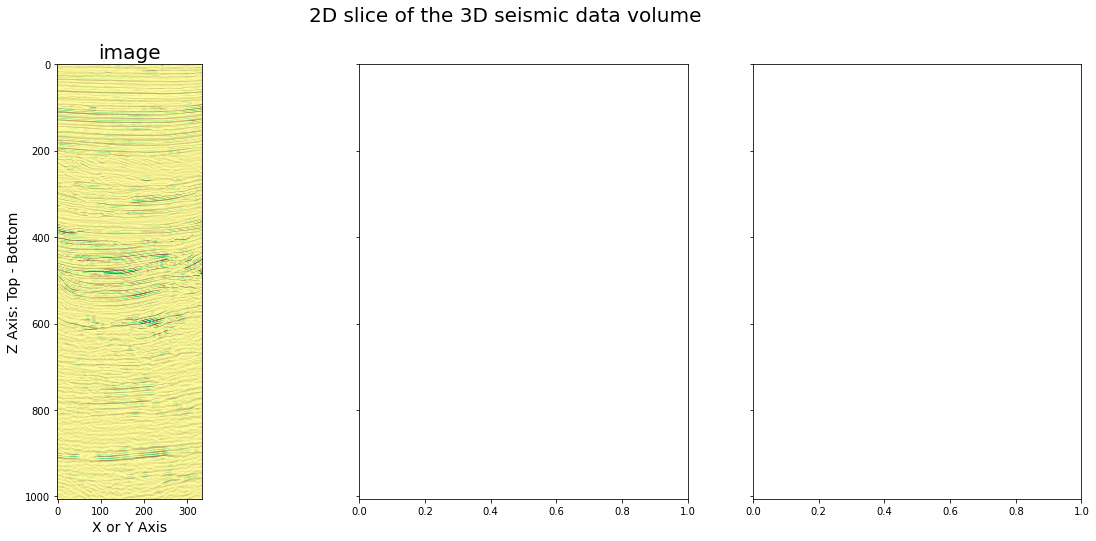

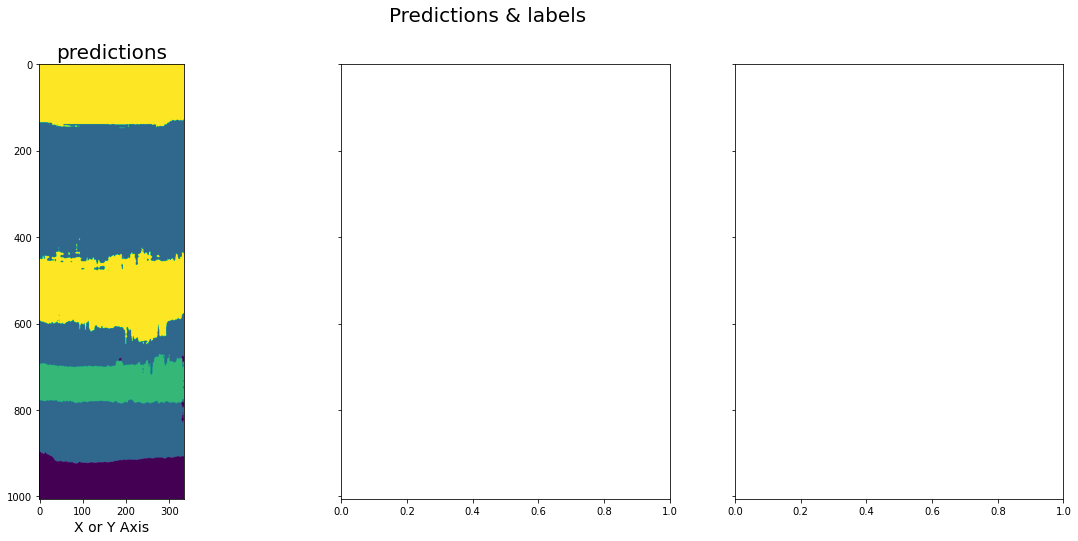

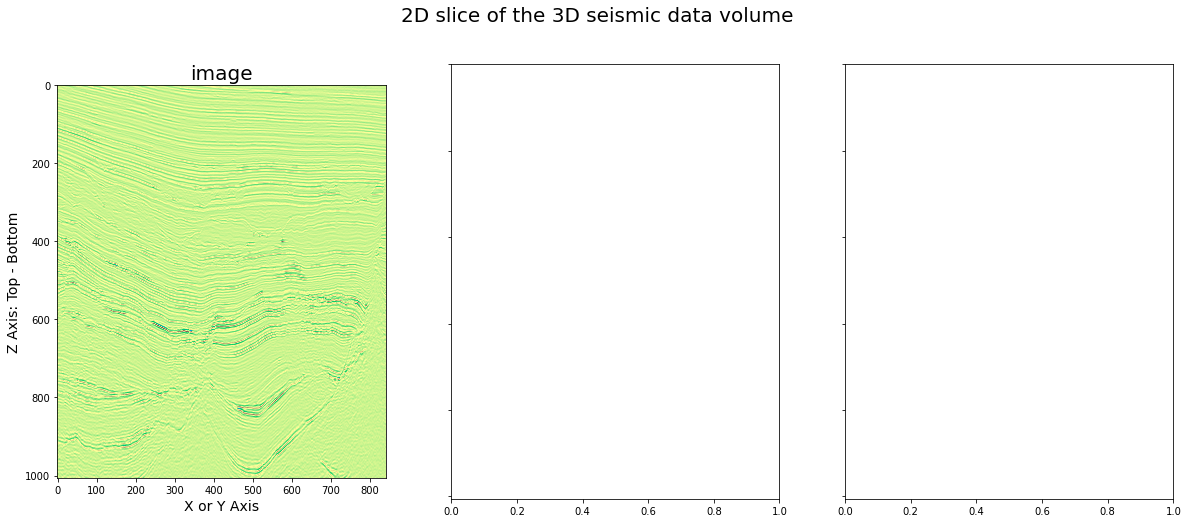

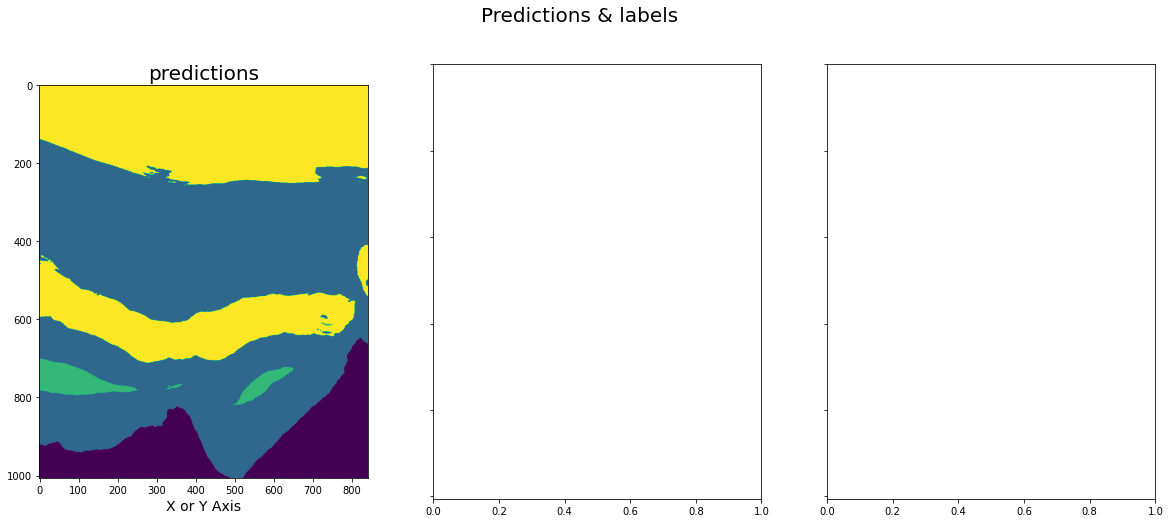

In [ ]:
# plot image & predictions
def plot_image_pred(image, pred=None, labels=None):

  # plot image & labels
  fig, ax = plt.subplots(1,3, sharey=True)
  fig.set_size_inches(20, 8)
  fig.suptitle("2D slice of the 3D seismic data volume", fontsize=20)
  ax[0].imshow(image, cmap='terrain')
  ax[0].set_xlabel('X or Y Axis', fontsize=14)
  ax[0].set_ylabel('Z Axis: Top - Bottom', fontsize=14)
  ax[0].set_title("image", fontsize=20)
  if labels is not None:
    print(np.unique(labels))
    ax[1].imshow(labels)
    ax[1].set_xlabel('X or Y Axis', fontsize=14)
    ax[1].set_title("labels", fontsize=20)
    ax[2].imshow(image, cmap='terrain')
    ax[2].imshow(labels, alpha=0.4, cmap='twilight')
    ax[2].set_xlabel('X or Y Axis', fontsize=14)
    ax[2].set_title("image + labels", fontsize=20)

  # plot pred & labels
  if pred is not None:
    fig, ax = plt.subplots(1,3, sharey=True)
    fig.set_size_inches(20, 8)
    fig.suptitle("Predictions & labels", fontsize=20)
    ax[0].imshow(pred)
    ax[0].set_xlabel('X or Y Axis', fontsize=14)
    ax[0].set_title("predictions", fontsize=20)
    if labels is not None:
      ax[1].imshow(labels)
      ax[1].set_xlabel('X or Y Axis', fontsize=14)
      ax[1].set_title("labels", fontsize=20)
      ax[2].imshow(pred.equal(labels))
      ax[2].set_xlabel('X or Y Axis', fontsize=14)
      ax[2].set_title("wrong predictions", fontsize=20)

plot_image_pred(test2_img[:,:,0], pred2[:,:,0])
plot_image_pred(test2_img[:,75,:], pred2[:,75,:])